```{index} single: application; airline seating allocation
```
```{index} single: solver; cbc
```
```{index} pandas dataframe
```
```{index} single: Pyomo; sets
```
```{index} stochastic optimization
```
```{index} chance constraints
```
```{index} sample average approximation
```
```{index} two-stage problem
```

# Airline seat allocation problem

## Attribution

The following problem statement is adapted from an exercise and examples presented by Birge and Louveaux (2011). 

* Birge, J. R., & Louveaux, F. (2011). Introduction to stochastic programming. Springer Science & Business Media.

The adaptations include a change to parameters for consistency among reformulations of the problem, and additional treatments for sample average approximation (SAA) with chance constraints.

## Problem description

An airline is deciding how to partition a new plane for the Amsterdam-Buenos Aires route. This plane can seat 200 economy-class passengers. A section can be created for first-class seats, but each of these seats takes the space of 2 economy-class seats. A business-class section can also be created, but each of these takes the space of 1.5 economy-class seats. The profit for a first-class ticket is three times the profit of an economy ticket, while a business-class ticket has a profit of two times an economy ticket's profit. Once the plane is partitioned into these seating classes, it cannot be changed. 

The airlines knows that the plane will not always be full in every section. The airline has initially identified three scenarios to consider with about equal frequency: 

1. Weekday morning and evening traffic;
2. Weekend traffic; and
3. Weekday midday traffic. 

Under Scenario 1 the airline thinks they can sell as many as 20 first-class tickets, 50 business-class tickets, and 200 economy tickets. Under Scenario 2 these figures are 10 , 24, and 175, while under Scenario 3, they are 6, 10, and 150, respectively. The following table summarizes the forecast demand for these three scenarios.

<center>

| Scenario | First-class seats | Business-class seats | Economy-class seats |
| :-- | :-: | :-: | :-: |
| (1) weekday morning and evening | 20 | 50 | 200 |
| (2) weekend | 10 | 24 | 175 |
| (3) weekday midday | 6 | 10 | 150 |
| **Average Scenario** | **12** | **28** | **175** |

</center>

The goal of the airline is to maximize ticket revenue. For marketing purposes, the airline will not sell more tickets than seats in each of the sections (hence no overbooking strategy). We further assume customers seeking a first-class or business-class seat will not downgrade if those seats are unavailable.

## Installation and imports

In [1]:
# install pyomo and select solver
import sys

SOLVER = "cbc"

if "google.colab" in sys.modules:
    !pip install highspy >/dev/null
    SOLVER = "appsi_highs"

In [2]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Problem data

Pandas DataFrames and Series are used to encode problem data in the following cell, and to encode problem solutions in subsequent cells.

In [3]:
# scenario data
demand = pd.DataFrame(
    {
        "morning and evening": {"F": 20, "B": 50, "E": 200},
        "weekend": {"F": 10, "B": 24, "E": 175},
        "midday": {"F": 6, "B": 10, "E": 150},
    }
).T

# global revenue and seat factor data
capacity = 200
revenue_factor = pd.Series({"F": 3.0, "B": 2.0, "E": 1.0})
seat_factor = pd.Series({"F": 2.0, "B": 1.5, "E": 1.0})

## Analytics

Prior to optimization, a useful first step is to prepare an analytics function to display performance for any given allocation of seats. The first-stage decision variables are the number of seats allocated for each class $c\in C$. We would like to provide a analysis showing the operational consequences for any proposed allocation of seats. For this purpose, we create a function ``seat_report()`` that show the tickets that can be sold in each scenario, the resulting revenue, and the unsatisfied demand ('spillage'). 

To establish a basis for analyzing possible solutions to the airline's problem, this function first is demonstrated for the case where the airplane is configured as entirely economy-class.


Seat Allocation


,F,B,E,TOTAL
seat allocation,0.0,0.0,200.0,200.0
economy equivalent seat allocation,0.0,0.0,200.0,200.0



Tickets Sold


,F,B,E
morning and evening,0,0,200
weekend,0,0,175
midday,0,0,150



Seats not Sold


,F,B,E
morning and evening,0,0,0
weekend,0,0,25
midday,0,0,50



Spillage (Unfulfilled Demand)


,F,B,E
morning and evening,20,50,0
weekend,10,24,0
midday,6,10,0



Expected Revenue (in units of economy ticket price): 175.00


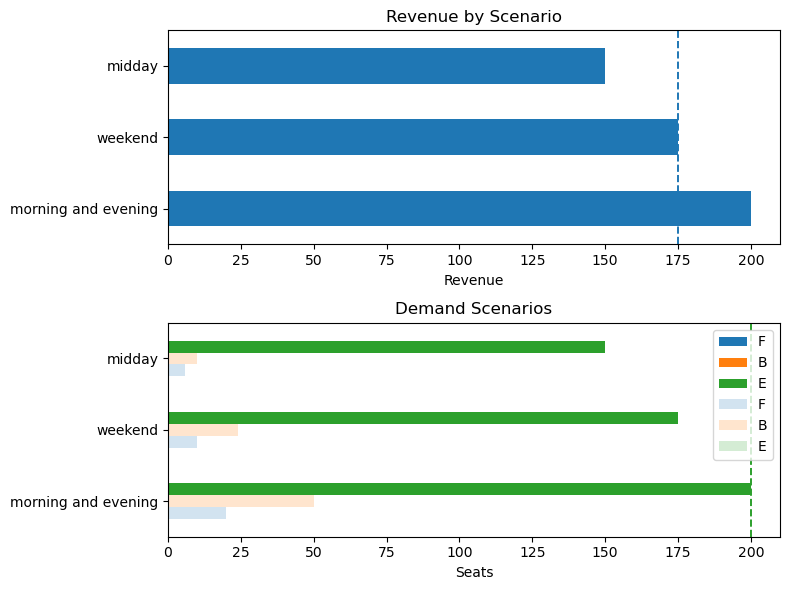

In [4]:
# function to report analytics for any given seat allocations
def seat_report(seats, demand):
    classes = seats.index

    # report seat allocation
    equivalent_seats = pd.DataFrame(
        {
            "seat allocation": {c: seats[c] for c in classes},
            "economy equivalent seat allocation": {
                c: seats[c] * seat_factor[c] for c in classes
            },
        }
    ).T
    equivalent_seats["TOTAL"] = equivalent_seats.sum(axis=1)
    print("\nSeat Allocation")
    display(equivalent_seats)

    # tickets sold is the minimum of available seats and demand
    tickets = pd.DataFrame()
    for c in classes:
        tickets[c] = np.minimum(seats[c], demand[c])
    print("\nTickets Sold")
    display(tickets)

    # seats unsold
    unsold = pd.DataFrame()
    for c in classes:
        unsold[c] = seats[c] - tickets[c]
    print("\nSeats not Sold")
    display(unsold)

    # spillage (unmet demand)
    spillage = demand - tickets
    print("\nSpillage (Unfulfilled Demand)")
    display(spillage)

    # compute revenue
    revenue = tickets.dot(revenue_factor)
    print(
        f"\nExpected Revenue (in units of economy ticket price): {revenue.mean():.2f}"
    )

    # charts
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    revenue.plot(ax=ax[0], kind="barh", title="Revenue by Scenario")
    ax[0].plot([revenue.mean()] * 2, ax[0].get_ylim(), "--", lw=1.4)
    ax[0].set_xlabel("Revenue")

    tickets[classes].plot(
        ax=ax[1], kind="barh", rot=0, stacked=False, title="Demand Scenarios"
    )
    demand[classes].plot(
        ax=ax[1],
        kind="barh",
        rot=0,
        stacked=False,
        title="Demand Scenarios",
        alpha=0.2,
    )
    for c in classes:
        ax[1].plot([seats[c]] * 2, ax[1].get_ylim(), "--", lw=1.4)
    ax[1].set_xlabel("Seats")
    fig.tight_layout()

    return


# a trial solution
seats_all_economy = pd.Series({"F": 0, "B": 0, "E": 200})
seat_report(seats_all_economy, demand)

## Model 1. Deterministic solution for the average demand scenario

A common starting point in stochastic optimization is to solve the deterministic problem where future demands are fixed at their mean values and compute the corresponding optimal solution. The resulting value of the objective has been called the *expectation of the expected value problem (EEV)* by Birge, or the *expected value of the mean (EVM)* solution by others.

Let us introduce the set $C$ of the three possible classes, i.e., $C=\{F,B,E\}$. The objective function is to maximize ticket revenue.

$$
\max_{s_c, t_c} \quad \sum_{c\in C} r_c t_c 
$$

where $r_c$ is the revenue from selling a ticket for a seat in class $c\in C$.

Let $s_c$ denote the number of seats of class $c \in C$ installed in the new plane. Let $f_c$ be the scale factor denoting the number of economy seats displaced by one seat in class $c \in C$. Then, since there is a total of 200 economy-class seats that could fit on the plane, the capacity constraint reads as

$$
    \sum_{c\in C} f_c s_c \leq 200,
$$

Let $\mu_c$ be the mean demand for seats of class $c\in C$, and let $t_c$ be the number of tickets of class $c\in C$ that are sold. To ensure we do not sell more tickets than available seats nor more than demand, we need to add two more constraints:

$$
\begin{align*}
    t_c & \leq s_c \qquad \forall \, c\in C \\
    t_c & \leq \mu_c \qquad \forall \, c\in C
\end{align*}
$$

Lastly, both ticket and seat variables need to be nonnegative integers, so we add the constraints $\bm{t}, \bm{s} \in \mathbb{Z}_+$. 

The following cell presents a Pyomo model implementing this model.


Seat Allocation


,F,B,E,TOTAL
seat allocation,12.0,28.0,134.0,174.0
economy equivalent seat allocation,24.0,42.0,134.0,200.0



Tickets Sold


,F,B,E
morning and evening,12.0,28.0,134.0
weekend,10.0,24.0,134.0
midday,6.0,10.0,134.0



Seats not Sold


,F,B,E
morning and evening,0.0,0.0,0.0
weekend,2.0,4.0,0.0
midday,6.0,18.0,0.0



Spillage (Unfulfilled Demand)


,F,B,E
morning and evening,8.0,22.0,66.0
weekend,0.0,0.0,41.0
midday,0.0,0.0,16.0



Expected Revenue (in units of economy ticket price): 203.33


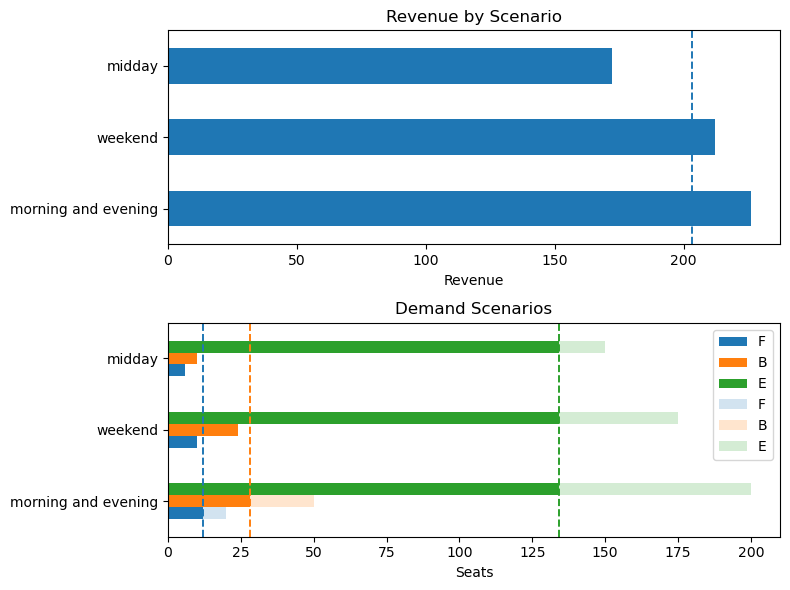

In [5]:
def airline_deterministic(demand):
    m = pyo.ConcreteModel("Airline seating (deterministic)")

    m.CLASSES = pyo.Set(initialize=demand.columns)

    # first stage variables and constraints
    m.seats = pyo.Var(m.CLASSES, domain=pyo.NonNegativeIntegers)

    @m.Constraint(m.CLASSES)
    def plane_seats(m, c):
        return sum(m.seats[c] * seat_factor[c] for c in m.CLASSES) <= capacity

    # second stage variable and constraints
    m.tickets = pyo.Var(m.CLASSES, domain=pyo.NonNegativeIntegers)

    @m.Constraint(m.CLASSES)
    def demand_limits(m, c):
        return m.tickets[c] <= demand[c].mean()

    @m.Constraint(m.CLASSES)
    def seat_limits(m, c):
        return m.tickets[c] <= m.seats[c]

    # objective
    @m.Objective(sense=pyo.maximize)
    def revenue(m):
        return sum(m.tickets[c] * revenue_factor[c] for c in m.CLASSES)

    return m


def airline_solve(m):
    pyo.SolverFactory(SOLVER).solve(m)
    return pd.Series({c: m.seats[c]() for c in m.CLASSES})


# Solve deterministic model to obtain the expectation of the expected value problem (EEV)
model_eev = airline_deterministic(demand)
seats_eev = airline_solve(model_eev)
seat_report(seats_eev, demand)

## Model 2. Two-stage stochastic optimization and its extensive form

If we assume demand is not certain, we can formulate a two-stage stochastic optimization problem. The first-stage or here-and-now variables are the $s_c$'s, those related to the seat allocations. Due to their dependence on the realized demand $\bm{z}$, the variables $t_c$'s describing the number of tickets sold, are second-stage or recourse decision variables. The full problem formulation is as follows: the first stage problem is

$$
\begin{align*}
    \max \quad & \mathbb E_{z} Q(\bm{s},\bm{z}) \\
    \textup{ s.t. } \quad & \sum_{c\in C} f_c s_c \leq 200,\\
    & \bm{s} \in \mathbb{Z}_+,
\end{align*}
$$

where $Q(\bm{s},\bm{z})$ is the value of the second-stage problem, defined as

$$
\begin{align*}
    Q(\bm{s},\bm{z}) := \max \quad & \sum_{c\in C} r_c t_{c}\\
    \textup{ s.t. } \quad 
    & t_c \leq s_c & \forall \, c\in C \\
    & t_c \leq z_c & \forall \, c\in C \\
    & \bm{t} \in \mathbb{Z}_+.
\end{align*}
$$

In view of the assumption that there is only a finite number $N=|S|$ of scenarios for ticket demand, we can write the extensive form of the two-stage stochastic optimization problem above and solve it exactly. To do so, we modify the second-stage variables $t_{c,s}$ so that they are indexed by both class $c$ and scenario $s$. The expectation can thus be replaced with the average revenue over the $N$ scenarios, that is

$$
\max \quad \sum_{s \in S} \frac{1}{N} \sum_{c\in C}  r_c t_{c, s},
$$

where the fraction $\frac{1}{N}$ appears since we assume that all $N$ scenarios are equally likely. The first stage constraint remains unchanged, while the second stage constraints are tuplicated for each scenario $s \in S$, namely

$$
\begin{align*}
t_{c,s} & \leq s_c & \forall \, c\in C \\
t_{c,s} & \leq z_{c, s} & \forall \, (c, s) \in C \times S
\end{align*}
$$

The following cell presents a Pyomo model implementing this model and solving it for the $N=3$ equiprobable scenarios introduced above.


Seat Allocation


,F,B,E,TOTAL
seat allocation,10.0,20.0,150.0,180.0
economy equivalent seat allocation,20.0,30.0,150.0,200.0



Tickets Sold


,F,B,E
morning and evening,10.0,20.0,150.0
weekend,10.0,20.0,150.0
midday,6.0,10.0,150.0



Seats not Sold


,F,B,E
morning and evening,0.0,0.0,0.0
weekend,0.0,0.0,0.0
midday,4.0,10.0,0.0



Spillage (Unfulfilled Demand)


,F,B,E
morning and evening,10.0,30.0,50.0
weekend,0.0,4.0,25.0
midday,0.0,0.0,0.0



Expected Revenue (in units of economy ticket price): 209.33


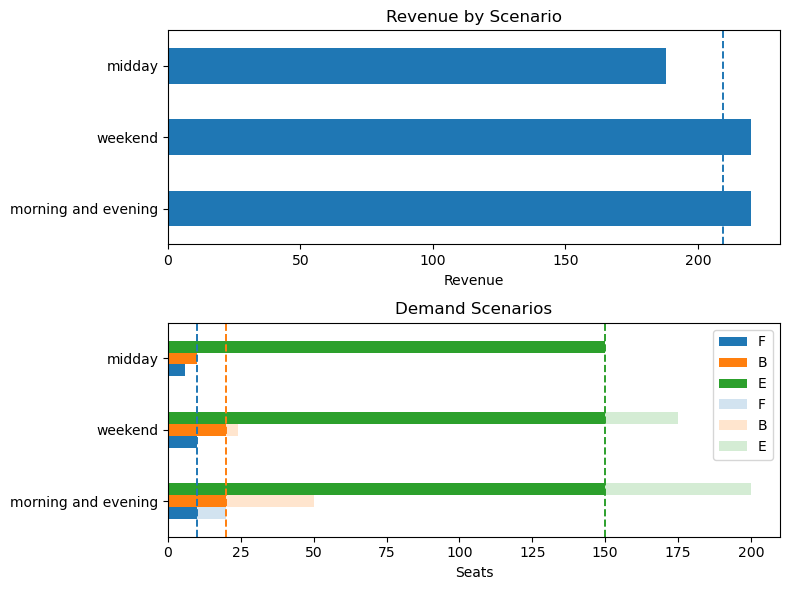

In [6]:
def airline_stochastic(demand):
    m = pyo.ConcreteModel("Airline seating (stochastic)")

    m.CLASSES = pyo.Set(initialize=demand.columns)
    m.SCENARIOS = pyo.Set(initialize=demand.index)

    # first stage variables and constraints
    m.seats = pyo.Var(m.CLASSES, domain=pyo.NonNegativeIntegers)

    @m.Constraint(m.CLASSES)
    def plane_seats(m, c):
        return sum(m.seats[c] * seat_factor[c] for c in m.CLASSES) <= capacity

    # second stage variable and constraints
    m.tickets = pyo.Var(m.CLASSES, m.SCENARIOS, domain=pyo.NonNegativeIntegers)

    @m.Constraint(m.CLASSES, m.SCENARIOS)
    def demand_limits(m, c, s):
        return m.tickets[c, s] <= demand[c][s]

    @m.Constraint(m.CLASSES, m.SCENARIOS)
    def seat_limits(m, c, s):
        return m.tickets[c, s] <= m.seats[c]

    # objective
    @m.Objective(sense=pyo.maximize)
    def revenue(m):
        return sum(
            m.tickets[c, s] * revenue_factor[c]
            for c in m.CLASSES
            for s in m.SCENARIOS
        )

    return m


# create and solve model for the three scenarios defined above
model_stochastic = airline_stochastic(demand)
seats_stochastic = airline_solve(model_stochastic)
seat_report(seats_stochastic, demand)

## Model 3. Adding chance constraints

The airline wishes a special guarantee for its clients enrolled in its loyalty program. In particular, it wants $98\%$ probability to cover the demand of first-class seats and $95\%$ probability to cover the demand of business-class seats (by clients of the loyalty program). First-class passengers are covered if they can purchase a first-class seat. Business-class passengers are covered if they purchase a business-class seat or upgrade to a first-class seat. 

Assume the demand of loyalty-program passengers is normally distributed as $z_F \sim \mathcal N(\mu_F, \sigma_F^2)$ and $z_B \sim \mathcal N(\mu_B, \sigma_B^2)$ for first-class and business, respectively, where the parameters are given in the table below. For completeness, we also include the parameters for economy-class passengers.

<center>

| | $\mu_{\cdot}$ | $\sigma_{\cdot}$ |
| :--: | :--: | :--: |
| F | 12 | 4 |
| B | 28 | 8 |
| E | 175 | 20 |

</center>

We further assume that the demands for first-class and business-class seats are independent of each other and of the scenario (time of the week).

Let $s_F$ be the number of first-class seats and $s_B$ the number of business seats. The probabilistic constraints are

$$
\mathbb P(s_F \geq z_F ) \geq 0.98, \qquad \text{ and } \qquad \mathbb P(s_F + s_B \geq z_F + z_B ) \geq 0.95.
$$

These are can be written equivalently as linear constraints, specifically 

$$
\frac{s_F - \mu_F}{\sigma_F} \geq \Phi^{-1}(0.98) \approx 2.054 \qquad \text{ and } \qquad \frac{(s_F + s_B) - (\mu_F + \mu_B)}{\sqrt{\sigma_F^2 + \sigma_B^2}} \geq \Phi^{-1}(0.95) \approx 1.645.
$$

For the second constraint, we use the fact that the sum of the two independent random variables $z_F$ and $z_B$ is normally distributed with mean $\mu_F + \mu_B$ and variance $\sigma_F^2 + \sigma_B^2$. 

We add these equivalent linear counterparts of the two chance constraints to the stochastic optimization model. Rather than writing a function to create a whole new model, we can use the prior function to create and add the two chance constraints using decorators.

,mu,sigma
F,12.0,4
B,28.0,16
E,175.0,20



Seat Allocation


,F,B,E,TOTAL
seat allocation,21.0,47.0,87.0,155.0
economy equivalent seat allocation,42.0,70.5,87.0,199.5



Tickets Sold


,F,B,E
morning and evening,20.0,47.0,87.0
weekend,10.0,24.0,87.0
midday,6.0,10.0,87.0



Seats not Sold


,F,B,E
morning and evening,1.0,0.0,0.0
weekend,11.0,23.0,0.0
midday,15.0,37.0,0.0



Spillage (Unfulfilled Demand)


,F,B,E
morning and evening,0.0,3.0,113.0
weekend,0.0,0.0,88.0
midday,0.0,0.0,63.0



Expected Revenue (in units of economy ticket price): 177.00


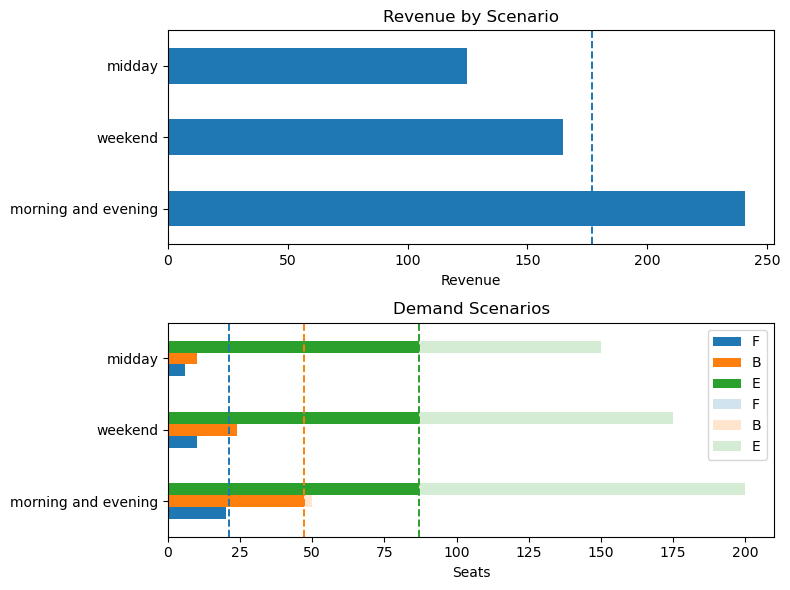

In [7]:
# import the scipy.stats.norm object needed to use the quantile function of the standard normal distribution
from scipy.stats import norm

# define the mean and standard deviation of the demand for each class
mu = demand.mean()
sigma = {"F": 4, "B": 16, "E": 20}
display(pd.DataFrame({"mu": mu, "sigma": sigma}))


# create a new model with chance constraints that takes as input also
# the target quality of service (QoS) levels for classes F and B
def airline_cc(demand, QoSF=0.98, QoSFB=0.95):
    # create two-stage stochastic model as before
    m = airline_stochastic(demand)

    # add equivalent counterparts of the two chance constraints to the first stage problem
    # the two coefficients related the inverse CDF of the standard normal are computed using the norm.ppf function
    @m.Constraint()
    def first_class(m):
        return (m.seats["F"] - mu["F"]) >= norm.ppf(QoSF) * sigma["F"]

    @m.Constraint()
    def business_class(m):
        return m.seats["F"] + m.seats["B"] - (mu["F"] + mu["B"]) >= norm.ppf(
            QoSFB
        ) * np.sqrt(sigma["F"] ** 2 + sigma["B"] ** 2)

    return m


# create and solve model
model_cc = airline_cc(demand)
seats_cc = airline_solve(model_cc)
seat_report(seats_cc, demand)

## Model 4. Solving the case of continuous demand distributions using the SAA method 

Let us now move past the simplifying assumption that there are only three equally likely scenarios and consider the case where the demand is described by a random vector $(z_F, z_B, z_E)$, where $z_c$ is the demand for seats of class $c\in C$. The demand for class $c$ is assumed to be independent and normally distributed with mean $\mu_c$ and variance $\sigma_c^2$ as reported in the following table

<center>

| | $\mu$ | $\sigma$ |
| :--: | :--: | :--: |
| F | 12 | 4 |
| B | 28 | 8 |
| E | 175 | 20 |

</center>

Note that we model the demand for each class using a continuous random variable, which is a simplification of the real world, where the ticket demand is always a discrete nonnegative number. Therefore, we round down all the obtained random numbers.

However, now that the number of scenarios is not finite anymore, we cannot solve the problem exactly. Instead, we can use the SAA method to approximate the expected value appearing in the objective function. The first step of the SAA is to generate a collection of $N$ scenarios $(z_{F,s}, z_{B,s}, z_{E,s})$ for $s=1,\ldots,N$. We can do this by sampling from the normal distributions with the given means and variances. 

For sake of generality, we create a script to generate scenarios in which the three demands have a general correlation structure captured by a correlation matrix $\bm{\rho}$.

### Scenario generation (uncorrelated case)


Model Covariance


,F,B,E
F,16,0,0
B,0,256,0
E,0,0,400


,mu (mean),sample mean,sigma (std),sample std
F,12.0,11.889,4,4.088936
B,28.0,28.626,16,15.051534
E,175.0,172.966,20,19.839669


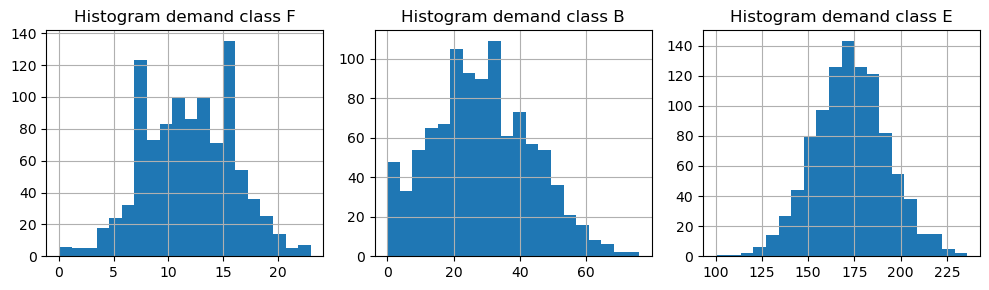

In [8]:
# sample size
N = 1000

# define the mean mu and standard deviation sigma of the demand for each class
mu = demand.mean()
sigma = {"F": 4, "B": 16, "E": 20}
classes = demand.columns

# build covariance matrix from covariances and correlations
s = np.array(list(sigma.values()))
S = np.diag(s) @ np.diag(s)
print("\nModel Covariance")
df = pd.DataFrame(S, index=classes, columns=classes)
display(df)

# generate N samples, round each demand entry to nearest integer, and correct non-negative values
seed = 0
rng = np.random.default_rng(seed)
samples = rng.multivariate_normal(list(mu), S, N).round()
demand_saa = pd.DataFrame(samples, columns=classes)
demand_saa[demand_saa < 0] = 0

# report sample means and standard deviations for each class
demand_saa_stats = pd.DataFrame(
    {
        "mu (mean)": mu,
        "sample mean": demand_saa.mean(),
        "sigma (std)": sigma,
        "sample std": demand_saa.std(),
    }
)
display(demand_saa_stats)

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for i, ci in enumerate(classes):
    demand_saa[ci].hist(ax=ax[i], bins=20)
    ax[i].set_title(f"Histogram demand class {ci}")
fig.tight_layout()

We also introduce a new function to report the solution and its features in this more general continuous demand case.

In [9]:
# function to report analytics for SAA case
def seat_report_saa(seats, demand):
    classes = seats.index

    # report seat allocation
    equivalent_seats = pd.DataFrame(
        {
            "seat allocation": {c: seats[c] for c in classes},
            "economy equivalent seat allocation": {
                c: seats[c] * seat_factor[c] for c in classes
            },
        }
    ).T
    equivalent_seats["TOTAL"] = equivalent_seats.sum(axis=1)
    print("\nSeat Allocation")
    display(equivalent_seats)

    # tickets sold
    tickets = pd.DataFrame()
    for c in classes:
        tickets[c] = np.minimum(seats[c], demand[c])

    print("\nMean Tickets Sold")
    display(tickets.mean())

    # seats unsold
    unsold = pd.DataFrame()
    for c in classes:
        unsold[c] = seats[c] - tickets[c]
    print("\nMean Seats not Sold")
    display(unsold.mean())

    # spillage (unmet demand)
    spillage = demand - tickets
    print("\nMean Spillage (Unfulfilled Demand)")
    display(spillage.mean())

    # compute revenue
    revenue = tickets.dot(revenue_factor)
    print(
        f"\nExpected Revenue (in units of economy ticket price): {revenue.mean():.2f}"
    )

    # charts
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    revenue.hist(ax=ax, bins=20)
    ax.set_title("Revenue Histogram")

    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    for i, c in enumerate(classes):
        tickets[c].hist(ax=ax[i], bins=20, alpha=0.4)
        demand[c].hist(ax=ax[i], alpha=0.4)
        ax[i].legend(["Tickets Sold", "Demand"])
        ax[i].set_xlim(0, 300)

    fig.tight_layout()
    return

We can now solve the stochastic optimization problem using the generated $N=1000$ scenarios. Note that we can use the previously defined function ``airline_stochastic`` to solve the model by simply calling it with a different dataframe as argument.


Seat Allocation


,F,B,E,TOTAL
seat allocation,11.0,20.0,148.0,179.0
economy equivalent seat allocation,22.0,30.0,148.0,200.0



Mean Tickets Sold


F      9.764
B     17.416
E    147.056
dtype: float64


Mean Seats not Sold


F    1.236
B    2.584
E    0.944
dtype: float64


Mean Spillage (Unfulfilled Demand)


F     2.125
B    11.210
E    25.910
dtype: float64


Expected Revenue (in units of economy ticket price): 211.18


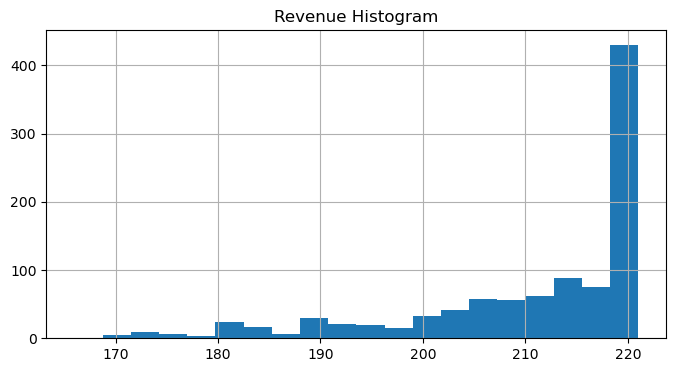

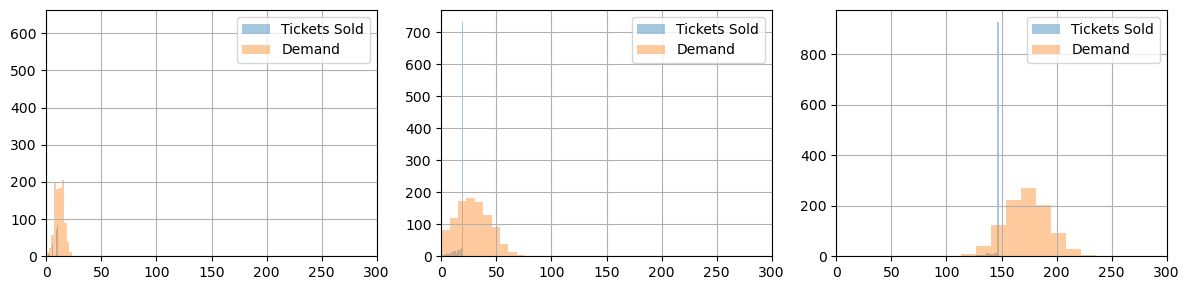

In [10]:
model_ssa = airline_stochastic(demand_saa)
seats_saa = airline_solve(model_ssa)
seat_report_saa(seats_saa, demand_saa)

## Model 5. Adding correlations between different demand types

Now assume the ticket demand for the three categories is captured by a $3$-dimensional multivariate normal distribution mean $\mu=(\mu_F, \mu_B, \mu_E)$, variances $(\sigma_F^2, \sigma_B^2, \sigma_E^2)$ and a symmetric correlation matrix 

$$
P = \left(
\begin{array}{ccc}
1 & \rho_{FB} & \rho_{FE} \\
\rho_{BF} & 1 & \rho_{BE}\\
\rho_{EF} & \rho_{EB} & 1 \\
\end{array}
\right)
$$

The covariance matrix is given by $\Sigma = \text{diag}(\sigma)\ P\ \text{diag}(\sigma)$ or

$$
\Sigma= \left(
\begin{array}{ccc}
 \sigma_F^2 & \rho_{FB}\sigma_F\sigma_B & \rho_{FE}\sigma_F\sigma_E \\
\rho_{BF}\sigma_B\sigma_F & \sigma_B^2 & \rho_{BE}\sigma_B\sigma_E\\
\rho_{EF}\sigma_E\sigma_F & \rho_{EB}\sigma_E\sigma_B & \sigma_E^2 \\
\end{array}
\right)
$$

We assume $\rho_{FB} = 0.6$, $\rho_{BE} = 0.4$ and $\rho_{FE} = 0.2$.
 
We now sample $N=1000$ scenarios from this multivariate correlated normal distribution and use the SAA method to approximate the solution of the two-stage stochastic optimization problem.

,mu,sigma
F,12.0,4
B,28.0,16
E,175.0,20


,mu,sample means
F,12.0,12.012
B,28.0,28.590
E,175.0,175.301


,sigma,sample std dev
F,4,3.951388
B,16,15.139984
E,20,20.147365



Model Covariance


,F,B,E
F,16.0,38.4,16.0
B,38.4,256.0,128.0
E,16.0,128.0,400.0



Sample Covariance


,F,B,E
F,15.613469,36.044965,12.434823
B,36.044965,229.219119,107.216627
E,12.434823,107.216627,405.916315


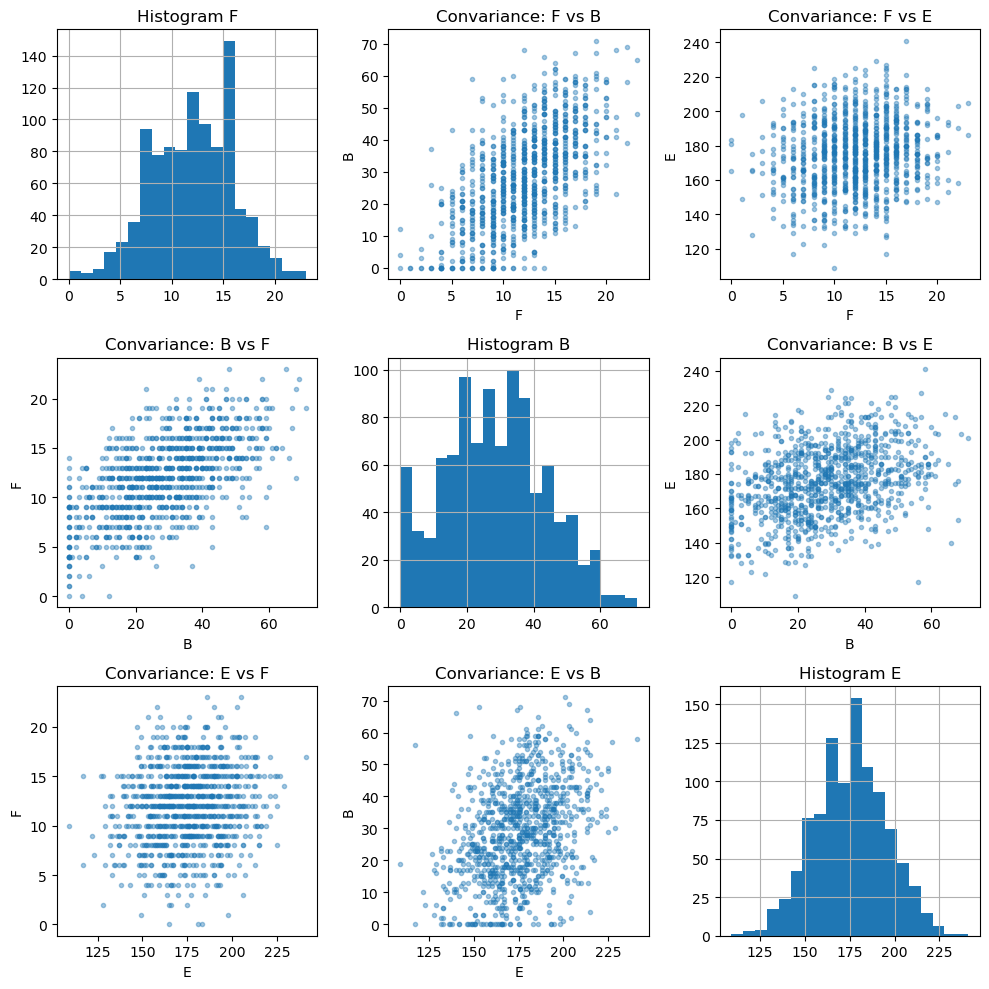

In [11]:
# sample size
N = 1000

# define the mean mu and standard deviation sigma of the demand for each class
mu = demand.mean()
sigma = {"F": 4, "B": 16, "E": 20}
display(pd.DataFrame({"mu": mu, "sigma": sigma}))

# correlation matrix
P = np.array([[1, 0.6, 0.2], [0.6, 1, 0.4], [0.2, 0.4, 1]])

# build covariance matrix from covariances and correlations
s = np.array(list(sigma.values()))
S = np.diag(s) @ P @ np.diag(s)

# create samples
np.random.seed(1)
samples = np.random.multivariate_normal(list(mu), S, N).round()

# truncate to integers and non-negative values
classes = demand.columns
demand_saa = pd.DataFrame(samples, columns=classes)
demand_saa[demand_saa < 0] = 0

df = pd.DataFrame(mu, columns=["mu"])
df["sample means"] = demand_saa.mean()
display(df)

df = pd.DataFrame(pd.Series(sigma), columns=["sigma"])
df["sample std dev"] = demand_saa.std()
display(df)

print("\nModel Covariance")
df = pd.DataFrame(S, index=classes, columns=classes)
display(df)

print("\nSample Covariance")
display(pd.DataFrame(demand_saa.cov()))

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i, ci in enumerate(classes):
    for j, cj in enumerate(classes):
        if i == j:
            demand_saa[ci].hist(ax=ax[i, i], bins=20)
            ax[i, i].set_title(f"Histogram {ci}")
        else:
            ax[i, j].plot(demand_saa[ci], demand_saa[cj], ".", alpha=0.4)
            ax[i, j].set_xlabel(ci)
            ax[i, j].set_ylabel(cj)
            ax[i, j].set_title(f"Convariance: {ci} vs {cj}")
fig.tight_layout()


Seat Allocation


,F,B,E,TOTAL
seat allocation,11.0,20.0,148.0,179.0
economy equivalent seat allocation,22.0,30.0,148.0,200.0



Mean Tickets Sold


F      9.863
B     17.303
E    147.184
dtype: float64


Mean Seats not Sold


F    1.137
B    2.697
E    0.816
dtype: float64


Mean Spillage (Unfulfilled Demand)


F     2.149
B    11.287
E    28.117
dtype: float64


Expected Revenue (in units of economy ticket price): 211.38


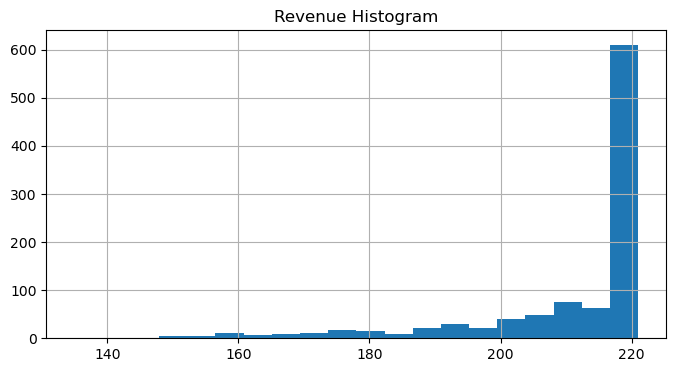

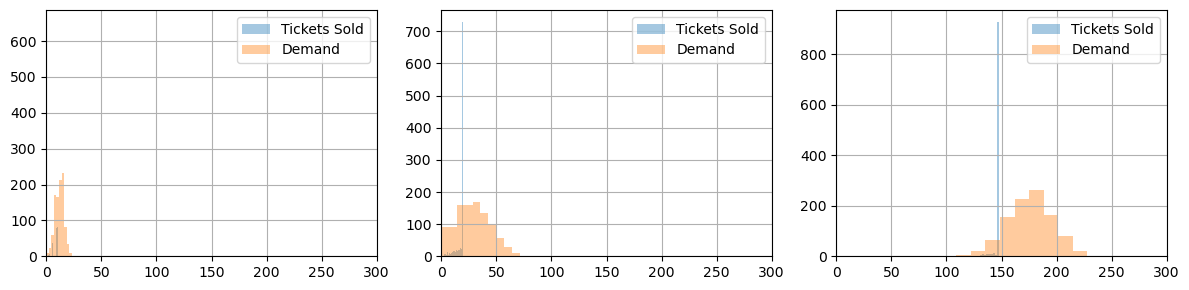

In [12]:
model_ssa = airline_stochastic(demand_saa)
seats_saa = airline_solve(model_ssa)
seat_report_saa(seats_saa, demand_saa)

## Model 6. Tackling chance constraints using SAA in the case of correlated demand

The linear counterparts of the chance constraints used above in Model 3 were derived under the assumption of independent normal distributions of demand for first-class and business travel. That assumption no longer holds for the case where demand scenarios are sampled from correlated distributions.

This final model replaces the chance constraints by approximating them using two linear constraints that explicitly track unsatisfied demand. In doing so, we introduce two new sets of integer variables $y_s$ and $w_s$ and a big-M constant and approximate the true multivariate distribution with the empirical one obtained from the sample. 

The first stage remains unchanged and so does the objective value of the second stage. The adjusted second-stage constraints are:

$$
\begin{align*}
    t_c & \leq s_c & \forall c\in C \\
    t_c & \leq z_{c, s} & \forall (c, s) \in C \times S \\
    s_F + M y_s & \geq z_{F, s} & \forall s \in  S\\
    s_F + s_B + M w_s & \geq z_{F, s} + z_{B,s} & \forall s \in  S \\
    \frac{1}{N} \sum_{s\in S} y_s & \leq 1 - 0.98 \\
    \frac{1}{N} \sum_{s\in S} z_s & \leq 1 - 0.95
\end{align*}
$$

where $y_s$ and $w_s$ are binary variables indicating those scenarios which do not satisfy the requirements of the airline's loyalty programs for first-class and business-class passengers. 

The following cell implements this new model. Note that the running time for the cell can be up to a few minutes for a large number of scenarios.


Seat Allocation


,F,B,E,TOTAL
seat allocation,20.0,50.0,85.0,155.0
economy equivalent seat allocation,40.0,75.0,85.0,200.0



Mean Tickets Sold


F    11.995
B    28.031
E    85.000
dtype: float64


Mean Seats not Sold


F     8.005
B    21.969
E     0.000
dtype: float64


Mean Spillage (Unfulfilled Demand)


F     0.017
B     0.559
E    90.301
dtype: float64


Expected Revenue (in units of economy ticket price): 177.05


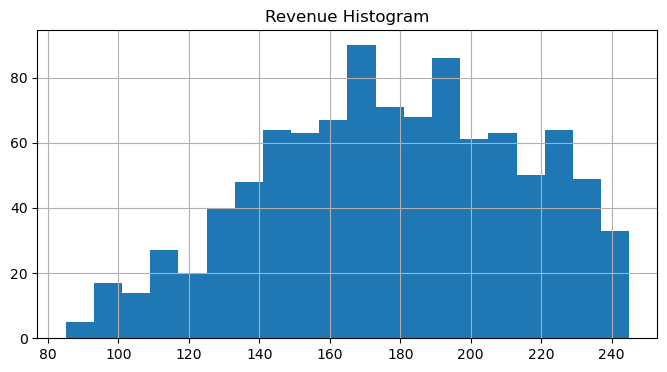

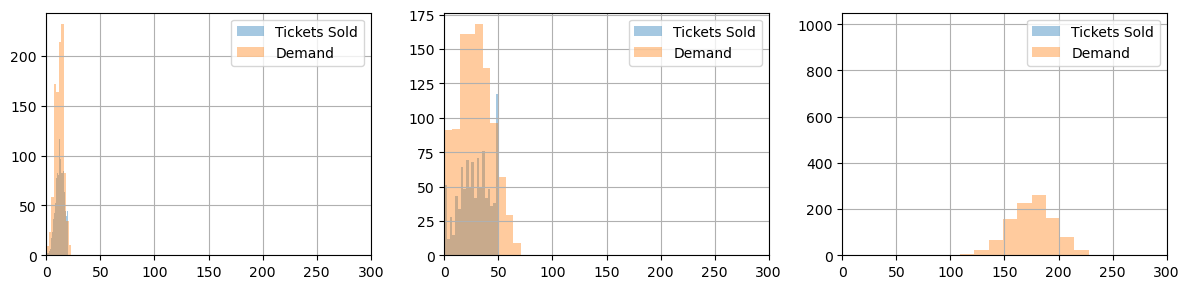

In [13]:
# define big M constant for chance constraints counterparts
bigM = 100


def airline_final(demand):
    m = pyo.ConcreteModel()

    m.CLASSES = pyo.Set(initialize=demand.columns)
    m.SCENARIOS = pyo.Set(initialize=demand.index)

    # first stage variables and constraints
    m.seats = pyo.Var(m.CLASSES, domain=pyo.NonNegativeIntegers)

    @m.Constraint(m.CLASSES)
    def plane_seats(m, c):
        return sum(m.seats[c] * seat_factor[c] for c in m.CLASSES) <= capacity

    # second stage variable and constraints
    m.tickets = pyo.Var(m.CLASSES, m.SCENARIOS, domain=pyo.NonNegativeIntegers)
    m.first_class = pyo.Var(m.SCENARIOS, domain=pyo.Binary)
    m.business_class = pyo.Var(m.SCENARIOS, domain=pyo.Binary)

    @m.Constraint(m.CLASSES, m.SCENARIOS)
    def demand_limits(m, c, s):
        return m.tickets[c, s] <= demand[c][s]

    @m.Constraint(m.CLASSES, m.SCENARIOS)
    def seat_limits(m, c, s):
        return m.tickets[c, s] <= m.seats[c]

    @m.Constraint(m.SCENARIOS)
    def first_class_loyality(m, s):
        return m.seats["F"] + bigM * m.first_class[s] >= demand["F"][s]

    @m.Constraint()
    def first_class_loyality_rate(m):
        return sum(m.first_class[s] for s in m.SCENARIOS) <= 0.02 * len(
            m.SCENARIOS
        )

    @m.Constraint(m.SCENARIOS)
    def business_class_loyality(m, s):
        return (
            m.seats["F"] + m.seats["B"] + bigM * m.business_class[s]
            >= demand["B"][s] + demand["F"][s]
        )

    @m.Constraint()
    def business_class_loyality_rate(m):
        return sum(m.business_class[s] for s in m.SCENARIOS) <= 0.05 * len(
            m.SCENARIOS
        )

    # objective
    @m.Objective(sense=pyo.maximize)
    def revenue(m):
        return sum(
            m.tickets[c, s] * revenue_factor[c]
            for c in m.CLASSES
            for s in m.SCENARIOS
        )

    return m


# create model
model = airline_final(demand_saa)
seats = airline_solve(model)
seat_report_saa(seats, demand_saa)

**Exercise**

Compared the results of using positive correlation in demand for first and business-class tickets results in lower expected revenue. What happens if there is no correlation, or there is negative correlation? Verify your predictions by simulation.